# Baseline Data Loading (Direct S3 Loader)

Script to load baseline virtual models directly from S3 without importing baseline_generator.

**Baseline Data S3 Structure**: {save_result_path}/data/{model_name}_baseline_virtual_models/
├── baseline_features.pkl      # DataFrame: n_samples × n_features
├── baseline_targets.pkl       # DataFrame: n_samples × 1 (outcome)
├── baseline_parameters.pkl    # DataFrame: n_samples × n_parameters
├── baseline_timecourses.pkl   # Timecourse data
└── baseline_metadata.pkl      # Generation metadata

**ML Results S3 Structure**: {save_result_path}/machine-learning/baseline/{model_name}/
├── results.pkl            # Full evaluation results DataFrame
├── summary-stats.csv      # Aggregated statistics
├── run-metadata.yml       # Run configuration and metadata
└── failed-tasks.csv       # Tasks that failed during processing (if any)

## Configuration

In [1]:
# Configuration variables
MODEL_NAME = "sy_simple"  # Can be string: "sy_simple" or list: ["sy_simple", "model_v2"]
COMPONENTS_TO_LOAD = ["features", "targets", "parameters", "metadata"]  # Which baseline components to load
ML_COMPONENTS_TO_LOAD = ["results", "summary", "metadata"]  # Which ML results components to load: "results", "summary", "metadata", "failed_tasks"
SAMPLE_SIZE = None  # None to load all, or integer to sample
LOAD_ML_RESULTS = True  # Set to True to load ML baseline evaluation results
SHOW_STATISTICS = True  # Set to False to skip statistics

## Initialization

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Set up project path - same pattern as other notebooks
path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find("project")
# slice the path from the index of 'project' to the end
project_path = path[: index_project + 7]
print(f"✅ Project path: {project_path}")

# Add src to Python path for imports
sys.path.insert(0, os.path.join(project_path, "src"))

# Import S3ConfigManager
from models.utils.s3_config_manager import S3ConfigManager

# Initialize S3 manager
s3_manager = S3ConfigManager()
print(f"✅ S3 connection established. Save result path: {s3_manager.save_result_path}")

✅ Project path: c:\Github\new-peak-project
✅ S3 connection successful. Bucket: bio-data
✅ S3 connection established. Save result path: new-peak-project/experiments/ch5-paper


## Direct S3 Loading Functions

In [3]:
def process_model_config(model_config):
    """
    Convert MODEL_NAME config to list of model names for processing.
    
    Args:
        model_config: Can be string (single model) or list (multiple models)
    
    Returns:
        List of model names
    """
    if isinstance(model_config, str):
        return [model_config]
    elif isinstance(model_config, list):
        return model_config
    else:
        raise ValueError(f"MODEL_NAME must be str or list, got {type(model_config)}")


def load_baseline_direct_single(model_name, components, s3_manager):
    """
    Load baseline components for a single model directly from S3.
    
    Args:
        model_name: Name of the model (string)
        components: List of components to load
        s3_manager: S3ConfigManager instance
        
    Returns:
        Dictionary of loaded components
    """
    gen_path = s3_manager.save_result_path
    folder_name = f"{model_name}_baseline_virtual_models"
    base_path = f"{gen_path}/data/{folder_name}"
    
    print(f"📊 Loading baseline data for model: {model_name}")
    print(f"   S3 path: {base_path}")
    
    # Map component names to file names
    file_mapping = {
        'features': 'baseline_features.pkl',
        'targets': 'baseline_targets.pkl',
        'parameters': 'baseline_parameters.pkl',
        'timecourses': 'baseline_timecourses.pkl',
        'metadata': 'baseline_metadata.pkl'
    }
    
    result = {}
    
    for component in components:
        if component in file_mapping:
            filename = file_mapping[component]
            s3_path = f"{base_path}/{filename}"
            
            try:
                data = s3_manager.load_data_from_path(s3_path, data_format="pkl")
                result[component] = data
                print(f"  ✅ Loaded {component}: {type(data).__name__}")
                if isinstance(data, pd.DataFrame):
                    print(f"    Shape: {data.shape}")
            except Exception as e:
                print(f"  ❌ Error loading {component} from {s3_path}: {e}")
                result[component] = None
        else:
            print(f"  ⚠️ Unknown component: {component}")
            result[component] = None
    
    return result


def load_baseline_direct(model_config, components, s3_manager):
    """
    Load baseline components directly from S3, handling both single and multiple models.
    
    Args:
        model_config: Can be string (single model) or list (multiple models)
        components: List of components to load (e.g., ["features", "targets", "parameters"])
        s3_manager: S3ConfigManager instance
        
    Returns:
        If single model: Dictionary of loaded components
        If multiple models: Dictionary {model_name: component_dict}
    """
    model_names = process_model_config(model_config)
    
    if len(model_names) == 1:
        return load_baseline_direct_single(model_names[0], components, s3_manager)
    else:
        return {model_name: load_baseline_direct_single(model_name, components, s3_manager) for model_name in model_names}


def load_ml_baseline_results_single(model_name, components, s3_manager):
    """
    Load ML baseline evaluation results for a single model directly from S3.
    
    Args:
        model_name: Name of the model (string)
        components: List of ML components to load: "results", "summary", "metadata", "failed_tasks"
        s3_manager: S3ConfigManager instance
        
    Returns:
        Dictionary of loaded ML results components
    """
    gen_path = s3_manager.save_result_path
    base_path = f"{gen_path}/machine-learning/baseline/{model_name}"
    
    print(f"🤖 Loading ML baseline results for model: {model_name}")
    print(f"   S3 path: {base_path}")
    
    # Map component names to file names and data formats
    file_mapping = {
        'results': ('results.pkl', 'pkl'),
        'summary': ('summary-stats.csv', 'csv'),
        'metadata': ('run-metadata.yml', 'txt'),
        'failed_tasks': ('failed-tasks.csv', 'csv')
    }
    
    result = {}
    
    for component in components:
        if component in file_mapping:
            filename, data_format = file_mapping[component]
            s3_path = f"{base_path}/{filename}"
            
            try:
                data = s3_manager.load_data_from_path(s3_path, data_format=data_format)
                result[component] = data
                print(f"  ✅ Loaded ML {component}: {type(data).__name__}")
                if isinstance(data, pd.DataFrame):
                    print(f"    Shape: {data.shape}")
            except Exception as e:
                print(f"  ⚠️ ML {component} not found or error loading from {s3_path}: {e}")
                result[component] = None
        else:
            print(f"  ⚠️ Unknown ML component: {component}")
            result[component] = None
    
    return result


def load_ml_baseline_results(model_config, components, s3_manager):
    """
    Load ML baseline evaluation results directly from S3, handling both single and multiple models.
    
    Args:
        model_config: Can be string (single model) or list (multiple models)
        components: List of ML components to load (e.g., ["results", "summary", "metadata"])
        s3_manager: S3ConfigManager instance
        
    Returns:
        If single model: Dictionary of loaded ML components
        If multiple models: Dictionary {model_name: ml_component_dict}
    """
    model_names = process_model_config(model_config)
    
    if len(model_names) == 1:
        return load_ml_baseline_results_single(model_names[0], components, s3_manager)
    else:
        return {model_name: load_ml_baseline_results_single(model_name, components, s3_manager) for model_name in model_names}

In [4]:
# Load the baseline data
baseline_data = load_baseline_direct(MODEL_NAME, COMPONENTS_TO_LOAD, s3_manager)

# Load ML baseline results if enabled
ml_results_data = None
if LOAD_ML_RESULTS and ML_COMPONENTS_TO_LOAD:
    print("\n" + "="*60)
    print("🤖 ML Baseline Results Loading")
    print("="*60)
    ml_results_data = load_ml_baseline_results(MODEL_NAME, ML_COMPONENTS_TO_LOAD, s3_manager)
    print("="*60)

📊 Loading baseline data for model: sy_simple
   S3 path: new-peak-project/experiments/ch5-paper/data/sy_simple_baseline_virtual_models


  ✅ Loaded features: DataFrame
    Shape: (2000, 9)


  ✅ Loaded targets: DataFrame
    Shape: (2000, 1)


  ✅ Loaded parameters: DataFrame
    Shape: (2000, 51)


  ✅ Loaded metadata: dict

🤖 ML Baseline Results Loading
🤖 Loading ML baseline results for model: sy_simple
   S3 path: new-peak-project/experiments/ch5-paper/machine-learning/baseline/sy_simple


  ✅ Loaded ML results: DataFrame
    Shape: (150, 9)


  ✅ Loaded ML summary: DataFrame
    Shape: (15, 14)


  ✅ Loaded ML metadata: str


In [5]:
if baseline_data and SAMPLE_SIZE:
    print(f"\n🔍 Creating sampled version ({SAMPLE_SIZE} samples)")
    sampled_data = {}
    
    for component, data in baseline_data.items():
        if data is not None and isinstance(data, pd.DataFrame):
            if len(data) > SAMPLE_SIZE:
                sampled_data[component] = data.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)
                print(f"  ✅ Sampled {component}: {sampled_data[component].shape}")
            else:
                sampled_data[component] = data
                print(f"  ⚠️ {component} has only {len(data)} samples, using all")
        else:
            sampled_data[component] = data
    
    # Update baseline_data with sampled version
    baseline_data = sampled_data

if baseline_data and SHOW_STATISTICS:
    print("\n📈 Basic Statistics:")
    print("=" * 50)
    
    for component, data in baseline_data.items():
        if data is not None and isinstance(data, pd.DataFrame):
            print(f"\n{component.upper()} Statistics:")
            print(f"  Number of samples: {len(data)}")
            print(f"  Number of features: {len(data.columns)}")
            
            # Basic numeric statistics
            numeric_cols = data.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                print(f"  Numeric columns: {len(numeric_cols)}")
                # Show statistics for first few columns
                for col in numeric_cols[:3]:
                    print(f"    {col}: mean={data[col].mean():.4f}, std={data[col].std():.4f}, range=[{data[col].min():.4f}, {data[col].max():.4f}]")

# ML Results Statistics
if ml_results_data and SHOW_STATISTICS:
    print("\n🤖 ML Results Statistics:")
    print("=" * 50)
    
    for component, data in ml_results_data.items():
        if data is not None:
            print(f"\nML {component.upper()} Statistics:")
            if isinstance(data, pd.DataFrame):
                print(f"  Shape: {data.shape}")
                print(f"  Columns: {list(data.columns)}")
                
                # Show summary for results DataFrame
                if component == "results" and not data.empty:
                    print(f"  Models evaluated: {data['Model'].nunique()}")
                    print(f"  Feature datasets: {data['Feature Data'].nunique()}")
                    print(f"  Mean R² Score: {data['R2 Score'].mean():.4f}")
                    print(f"  Mean MSE: {data['Mean Squared Error'].mean():.4f}")
                    print(f"  Mean Pearson Correlation: {data['Pearson Correlation'].mean():.4f}")
                elif component == "summary" and not data.empty:
                    print(f"  Summary rows: {len(data)}")
                    print(f"  Models summarized: {data['Model'].nunique()}")
                    print(f"  Feature datasets summarized: {data['Feature Data'].nunique()}")
            elif isinstance(data, dict):
                print(f"  Type: Dictionary with keys: {list(data.keys())}")
                # Show a few key metrics from metadata
                if component == "metadata":
                    print(f"  Experiment type: {data.get('experiment_type', 'N/A')}")
                    print(f"  Model name: {data.get('model_name', 'N/A')}")
                    print(f"  Timestamp: {data.get('timestamp', 'N/A')}")
            else:
                print(f"  Type: {type(data).__name__}")
                print(f"  Content: {str(data)[:100]}...")


📈 Basic Statistics:

FEATURES Statistics:
  Number of samples: 2000
  Number of features: 9
  Numeric columns: 9
    R1: mean=708.5194, std=398.7111, range=[108.9803, 4565.9002]
    R2: mean=341.4824, std=190.3874, range=[59.0742, 1698.4141]
    R3: mean=892.6998, std=466.4331, range=[88.4579, 4425.0961]

TARGETS Statistics:
  Number of samples: 2000
  Number of features: 1
  Numeric columns: 1
    Oa: mean=42.7714, std=25.6482, range=[6.7326, 246.5209]

PARAMETERS Statistics:
  Number of samples: 2000
  Number of features: 51
  Numeric columns: 51
    Km_J0: mean=97.2616, std=9.6535, range=[63.1951, 140.6850]
    Vmax_J0: mean=12.6945, std=1.2925, range=[9.1978, 17.6368]
    Km_J1: mean=116.8055, std=11.7856, range=[84.9367, 163.2445]

🤖 ML Results Statistics:

ML RESULTS Statistics:
  Shape: (150, 9)
  Columns: ['Model', 'Feature Data', 'Mean Squared Error', 'R2 Score', 'Pearson Correlation', 'Pearson P-Value', 'experiment_type', 'model_name', 'evaluation_timestamp']
  Models evalua

In [6]:
ml_data_df = ml_results_data['results']

In [7]:
ml_data_df

,Model,Feature Data,Mean Squared Error,R2 Score,Pearson Correlation,Pearson P-Value,experiment_type,model_name,evaluation_timestamp
0,Linear Regression,original_features,624.448028,0.120669,0.356541,1.960104e-13,baseline-dynamics-v1,sy_simple,2026-01-02T14:56:09.240460
1,Linear Regression,original_features,534.012116,0.161838,0.402763,4.946960e-17,baseline-dynamics-v1,sy_simple,2026-01-02T14:56:09.240460
2,Linear Regression,original_features,496.704544,0.191191,0.439973,2.290690e-20,baseline-dynamics-v1,sy_simple,2026-01-02T14:56:09.240460
3,Linear Regression,original_features,554.077843,0.182426,0.437081,4.307378e-20,baseline-dynamics-v1,sy_simple,2026-01-02T14:56:09.240460
4,Linear Regression,original_features,506.466918,0.113703,0.352456,3.831386e-13,baseline-dynamics-v1,sy_simple,2026-01-02T14:56:09.240460
...,...,...,...,...,...,...,...,...,...
145,Neural Network,last_time_points,581.178014,0.183939,0.430970,1.603281e-19,baseline-dynamics-v1,sy_simple,2026-01-02T14:56:09.240460
146,Neural Network,last_time_points,639.414573,0.075194,0.315771,1.035222e-10,baseline-dynamics-v1,sy_simple,2026-01-02T14:56:09.240460
147,Neural Network,last_time_points,571.293131,0.132538,0.383339,1.888468e-15,baseline-dynamics-v1,sy_simple,2026-01-02T14:56:09.240460
148,Neural Network,last_time_points,638.453646,0.086119,0.327385,1.905423e-11,baseline-dynamics-v1,sy_simple,2026-01-02T14:56:09.240460


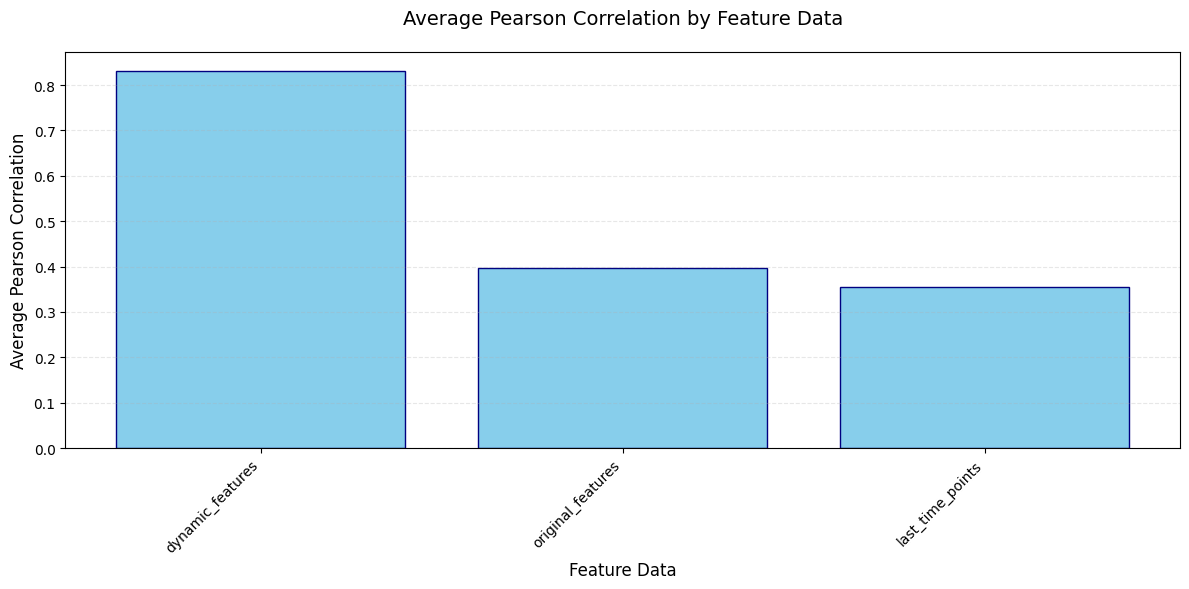

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Simple bar chart with sorting
plt.figure(figsize=(12, 6))

# Calculate average R2 for each feature
avg_r2 = ml_data_df.groupby("Feature Data")["Pearson Correlation"].mean().sort_values(ascending=False)

# Plot
plt.bar(range(len(avg_r2)), avg_r2.values, color="skyblue", edgecolor="navy")
plt.xticks(range(len(avg_r2)), avg_r2.index, rotation=45, ha="right", fontsize=10)
plt.ylabel("Average Pearson Correlation", fontsize=12)
plt.xlabel("Feature Data", fontsize=12)
plt.title("Average Pearson Correlation by Feature Data", fontsize=14, pad=20)
plt.grid(axis="y", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

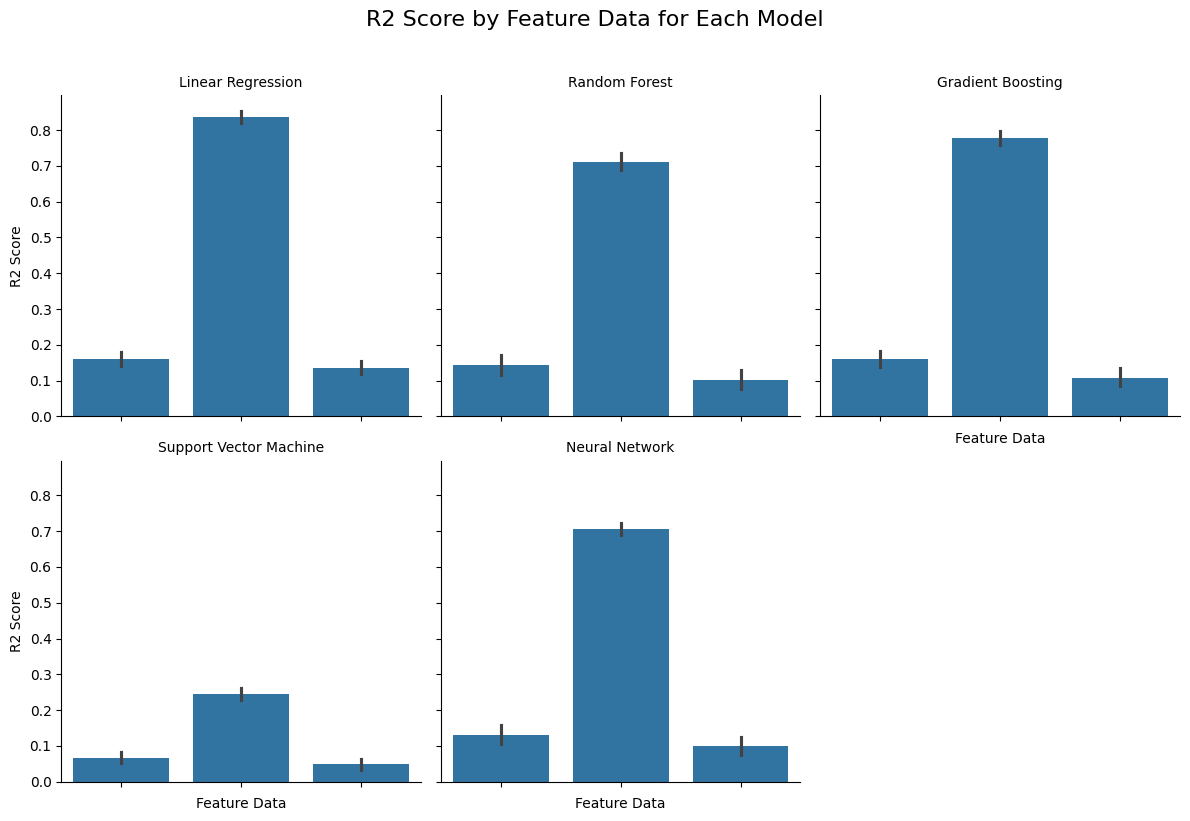

: 

: 

: 

: 

In [ ]:
import seaborn as sns
# Facet grid by model
g = sns.FacetGrid(ml_data_df, col='Model', col_wrap=3, height=4, sharey=True)
g.map(sns.barplot, 'Feature Data', 'R2 Score', order=ml_data_df['Feature Data'].value_counts().index[:10])
g.set_xticklabels(rotation=45, ha='right')
g.set_titles("{col_name}")
g.fig.suptitle('R2 Score by Feature Data for Each Model', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

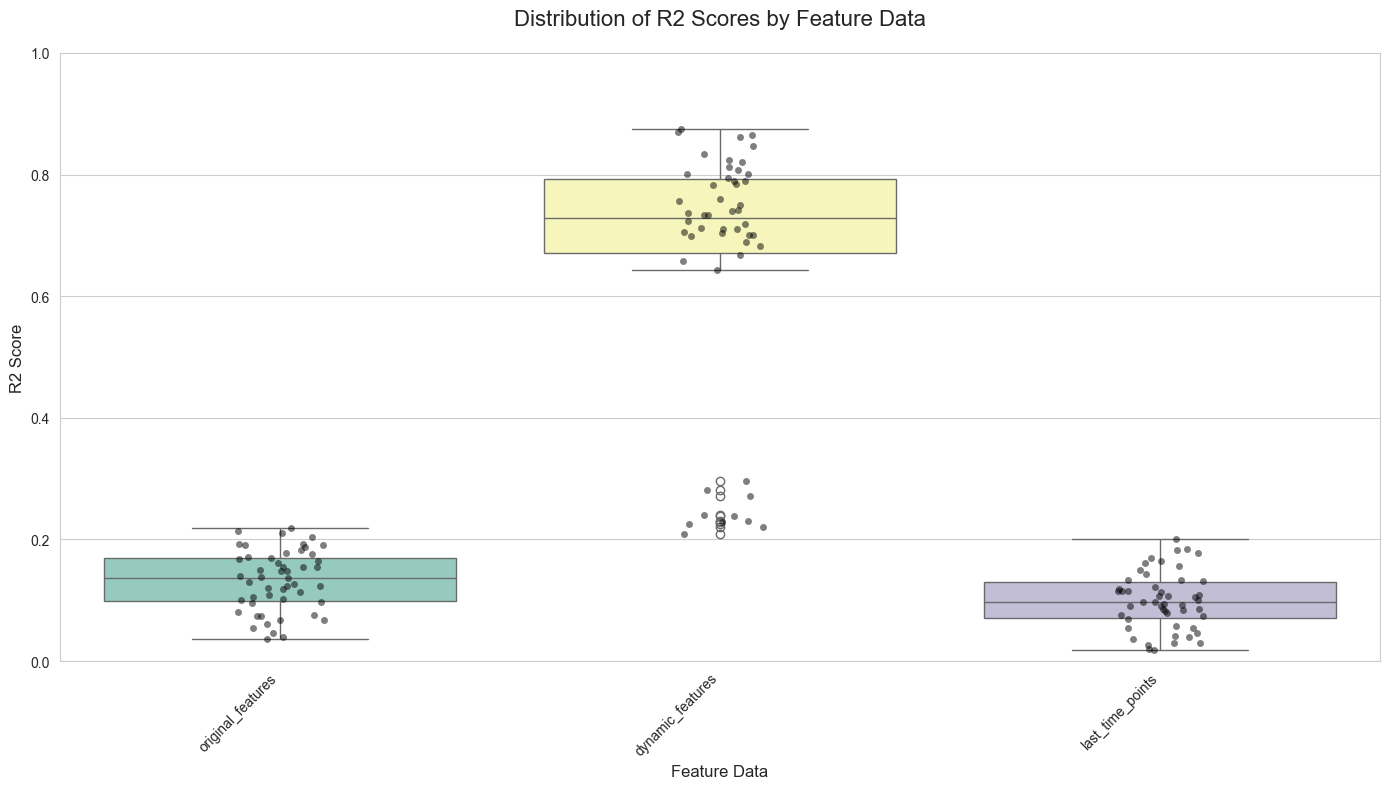

: 

: 

: 

: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))
df = ml_data_df.copy()
# Option 1: Box plot (good for comparing distributions)
if df['Feature Data'].nunique() <= 15:
    ax = sns.boxplot(x='Feature Data', y='R2 Score', data=df, palette='Set3')
    ax = sns.stripplot(x='Feature Data', y='R2 Score', data=df, 
                      color='black', alpha=0.5, size=5, jitter=True)
    plt.title('Distribution of R2 Scores by Feature Data', fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1 if df['R2 Score'].max() <= 1 else None)

# Option 2: Bar plot with confidence intervals
elif df['Feature Data'].nunique() <= 20:
    ax = sns.barplot(x='Feature Data', y='R2 Score', data=df, 
                    ci='sd', capsize=0.1, palette='viridis', errcolor='black')
    plt.title('Average R2 Score with Standard Deviation by Feature Data', fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1 if df['R2 Score'].max() <= 1 else None)
    
    # Add value labels
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', xytext=(0, 10), 
                   textcoords='offset points', fontsize=9)

# Option 3: Scatter plot for many unique features
else:
    ax = sns.scatterplot(x='Feature Data', y='R2 Score', hue='model_name', 
                        size='Mean Squared Error', sizes=(50, 300),
                        alpha=0.7, data=df, palette='tab10')
    plt.title('R2 Score vs Feature Data (colored by model)', fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Model Name', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.ylabel('R2 Score', fontsize=12)
plt.xlabel('Feature Data', fontsize=12)
plt.tight_layout()
plt.show()